In [60]:
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from datetime import date
from math import log, sqrt, exp
from scipy.stats import norm

# Classes

## Underlyings

In [97]:
class Stock:
    def __init__(self, ticker, price, dividend_yield=0.0):
        self.ticker = ticker
        self.price = price
        self.dividend_yield = dividend_yield

    def __repr__(self):
        return f"Stock(ticker='{self.ticker}', price={self.price}, dividend_yield={self.dividend_yield})"


## Options

### Vanilla options

In [142]:
class European_Option:
    def __init__(self, underlying, strike, expiry, option_type = "call"):
        self.underlying = underlying
        self.strike = strike
        self.expiry = expiry
        self.option_type = option_type.lower()
        self.style = "european"  
    
    def payoff(self, spot_price):
        if self.option_type == "call":
            return max(0, spot_price - self.strike)
        if self.option_type == "put":
            return max(0, self.strike - spot_price)
        else:
            raise ValueError('Option type should be either call or put')
            
    def BS_price(self, S, sigma, r, dividend_rate = 0):
        # for now not implementing pricing with dividends
        K = self.strike
        t = (self.expiry - date.today()).days/365
        
        d1 = (log(S/K) + (r + sigma**2/2)*t)/(sigma*sqrt(t))
        d2 = d1 - sigma*sqrt(t)
        
        call_price = norm.cdf(d1)*S - norm.cdf(d2)*K*exp(-r*t)
        put_price = K*exp(-r*t) - S + call_price
        
        if self.option_type == "call":
            return call_price
        if self.option_type == "put":
            return put_price
        
    def greeks(self, S, sigma, r, dividend_rate = 0):
        # implementing only delta for call for now 
        greeks = {}
        K = self.strike
        t = (self.expiry - date.today()).days / 365  # Use same time unit as BS_price
        d1 = (log(S/K) + (r - dividend_rate + 0.5 * sigma**2) * t) / (sigma * sqrt(t))

        if self.option_type == "call":
            delta = exp(-dividend_rate * t) * norm.cdf(d1)
            greeks['delta'] = delta
        elif self.option_type == "put":
            delta = -exp(-dividend_rate * t) * norm.cdf(-d1)
            greeks['delta'] = delta

        return greeks
        
    def plot_payoff(self, min_price = None, max_price = None, num = 100):
        if min_price is None:
            min_price = 0.5 * self.strike  
        if max_price is None:
            max_price = 1.5 * self.strike
        
        spot_prices = np.linspace(min_price, max_price, num)
        payoffs = [self.payoff(price) for price in spot_prices]
        
        plt.figure(figsize=(8, 6))
        plt.plot(spot_prices, payoffs, label=f"{self.option_type.capitalize()} Option Payoff - " + self.underlying.ticker.capitalize())
        plt.grid(True)
        plt.legend()
        plt.show()
        
    def __repr__(self):
        return (f"{self.style.capitalize()} {self.option_type.capitalize()} Option on {self.underlying.ticker} "
                f"with strike {self.strike} expiring on {self.expiry}")


### Exotic options

In [143]:
# TBD

### Portfolios

In [144]:
class OptionPosition:
    def __init__(self, option, quantity=1):
        """
        Parameters:
            option: An instance of an option (e.g., European_Option)
            quantity: Number of contracts (positive for long, negative for short)
        """
        self.option = option
        self.quantity = quantity

    def payoff(self, spot_price):
        """
        Calculate the payoff for this position at a given spot price.
        """
        return self.quantity * self.option.payoff(spot_price)
    
    def __repr__(self):
        # Returns a string like "AAPL call option: 1" or "AAPL put option: -2"
        return f"{self.option.underlying.ticker} {self.option.option_type} option: {self.quantity}"
    
    
class Portfolio:
    def __init__(self):
        self.positions = []
        self.cost = 0

    def add_position(self, option, quantity, cost = 0):
        """
        Add an option position to the portfolio.
        If a position with the same option exists, update its quantity.
        If the quantity becomes zero, remove the position.
        """
        self.cost += cost
        # Search for an existing position that matches the option.
        for pos in self.positions:
            if (pos.option.underlying.ticker == option.underlying.ticker and
                pos.option.strike == option.strike and
                pos.option.expiry == option.expiry and
                pos.option.option_type == option.option_type):
                pos.quantity += quantity
                # Remove the position if the quantity becomes zero.
                if pos.quantity == 0:
                    self.positions.remove(pos)
                return  # Exit after updating
        
        # If no matching position exists and quantity is non-zero, add a new position.
        if quantity != 0:
            self.positions.append(OptionPosition(option, quantity))
        
    def clear_position(self, option, quantity):
        self.positions

    def portfolio_payoff(self, spot_prices):
        """
        Calculate the net payoff of the portfolio over an array of spot prices.
        
        Parameters:
            spot_prices: A NumPy array of underlying prices.
            
        Returns:
            A NumPy array of net payoffs.
        """
        net_payoff = np.zeros_like(spot_prices)
        for position in self.positions:
            # Compute each position's payoff and add it to the net payoff
            net_payoff += np.array([position.payoff(price) for price in spot_prices])
        return net_payoff

    def plot_payoff(self, min_price=None, max_price=None, num=100, show_cost=False):
        """
        Plot the net payoff of the portfolio over a range of underlying prices.
        If show_cost is True, shift the payoff by subtracting the portfolio's cost.
        """
        if not self.positions:
            raise ValueError("Portfolio is empty. Please add some positions first.")
        
        # For simplicity, use the first option's strike as a reference for price range.
        ref_strike = self.positions[0].option.strike
        if min_price is None:
            min_price = 0.5 * ref_strike
        if max_price is None:
            max_price = 1.5 * ref_strike
        
        spot_prices = np.linspace(min_price, max_price, num)
        net_payoff = self.portfolio_payoff(spot_prices)
        
        if show_cost:
            # Subtract the total cost from the payoff to reflect the net profit.
            net_payoff = net_payoff - self.cost
        
        plt.figure(figsize=(8, 6))
        plt.plot(spot_prices, net_payoff, label="Portfolio Payoff")
        plt.xlabel("Underlying Price")
        plt.ylabel("Net Payoff")
        title = "Portfolio Payoff Diagram"
        if show_cost:
            title += f" (Adjusted by cost: {self.cost})"
        plt.title(title)
        plt.grid(True)
        plt.legend()
        plt.show()

# Analysis

## Initializing options

In [145]:
aapl = Stock("AAPL", 244.6)

In [146]:
aapl

Stock(ticker='AAPL', price=244.6, dividend_yield=0.0)

In [147]:
# create a european call option on aapl with strike price 250 and expiry in 1 month
aapl_call = European_Option(underlying=aapl, strike=250, expiry=date(2025,3,23), option_type="call")
aapl_put = European_Option(underlying=aapl, strike=250, expiry=date(2025,3,23), option_type="put")

In [148]:
aapl_call.BS_price(S=aapl.price, sigma = 0.2, r=0.01)

2.962919434193026

In [149]:
aapl_call.greeks(S = aapl.price, sigma = 0.2, r = 0.01)['delta']

0.3527403058475824

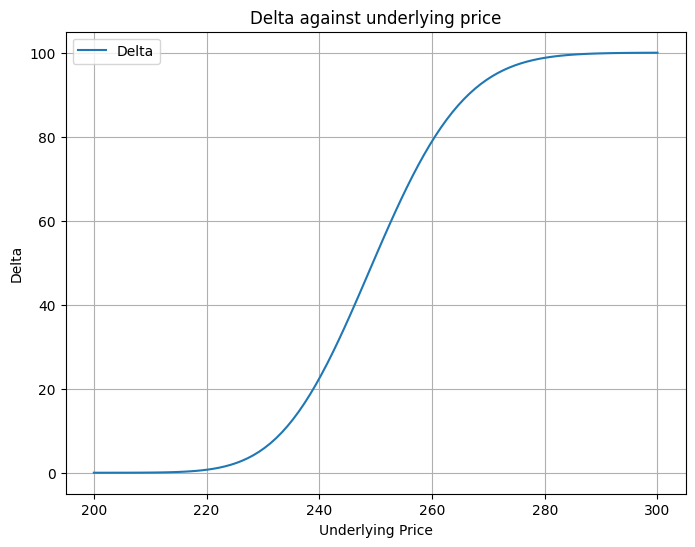

In [152]:
min_price = 200
max_price = 300
num = 100
spot_prices = np.linspace(min_price, max_price, num)
deltas = np.zeros_like(spot_prices)
for spot in spot_prices:
    deltas += np.array([aapl_call.greeks(S = spot, sigma = 0.2, r = 0.01)['delta'] for spot in spot_prices])


plt.figure(figsize=(8, 6))
plt.plot(spot_prices, deltas, label="Delta")
plt.xlabel("Underlying Price")
plt.ylabel("Delta")
title = "Delta against underlying price"

plt.title(title)
plt.grid(True)
plt.legend()
plt.show()

In [140]:
(aapl_call.expiry - date.today()).days

25

In [141]:
(aapl_call.expiry - date.today()).days/252

0.0992063492063492

## European call and put options

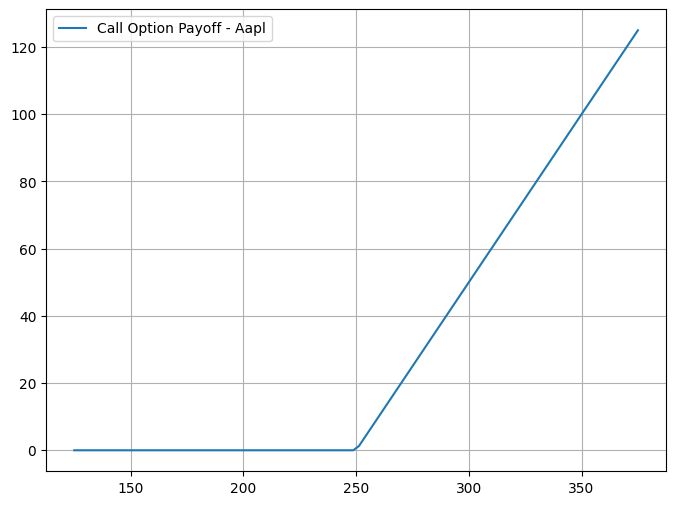

In [9]:
aapl_call.plot_payoff()

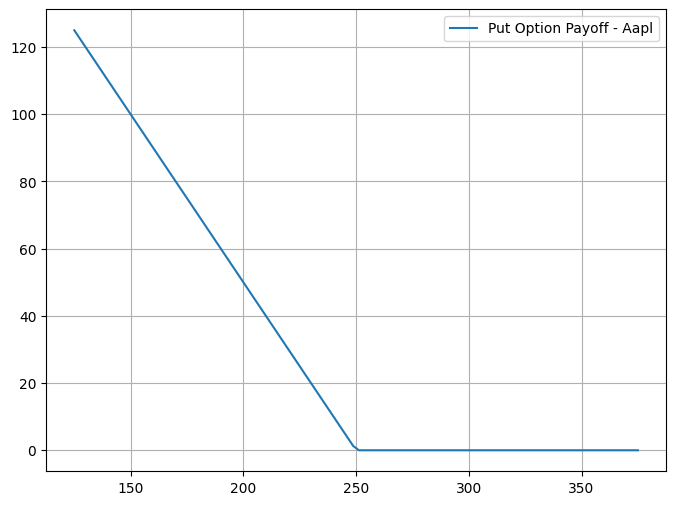

In [10]:
aapl_put.plot_payoff()

## Basic options strategies

### Bull call spread
Bull call spread is a strategy involving buying a call option and selling another call option with the same expiry date but higher strike price.

In [11]:
portfolio = Portfolio()
portfolio.add_position(option=European_Option(underlying=aapl, strike=230, expiry=date(2025,3,23), option_type="call"), quantity=1)
portfolio.add_position(option=European_Option(underlying=aapl, strike=270, expiry=date(2025,3,23), option_type="call"), quantity=-1)

In [12]:
portfolio.positions # Add expiry and strike to display 

[AAPL call option: 1, AAPL call option: -1]

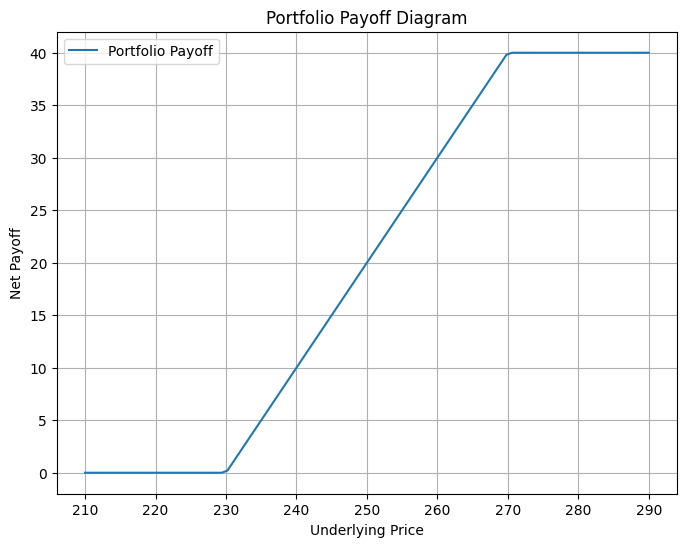

In [13]:
portfolio.plot_payoff(min_price=210, max_price=290)

### Bear put spread
The bear put spread is a strategy where you simultaneously buy put options and sell the same number of puts at a lower strike price. 

In [16]:
portfolio = Portfolio()
portfolio.add_position(option=European_Option(underlying=aapl, strike=270, expiry=date(2025,3,23), option_type="put"), quantity=1)
portfolio.add_position(option=European_Option(underlying=aapl, strike=230, expiry=date(2025,3,23), option_type="put"), quantity=-1)

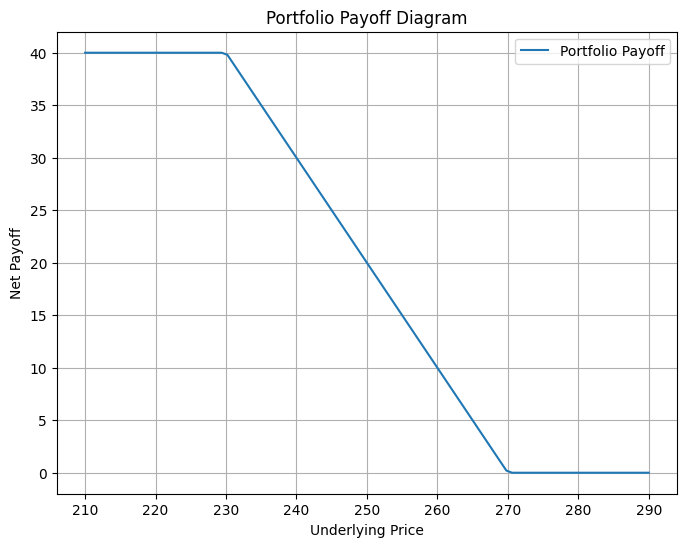

In [17]:
portfolio.plot_payoff(min_price=210, max_price=290)

### strategy 3

In [26]:
portfolio = Portfolio()
portfolio.add_position(option = aapl_call, quantity = 1, cost = 6)

In [27]:
portfolio.cost

6

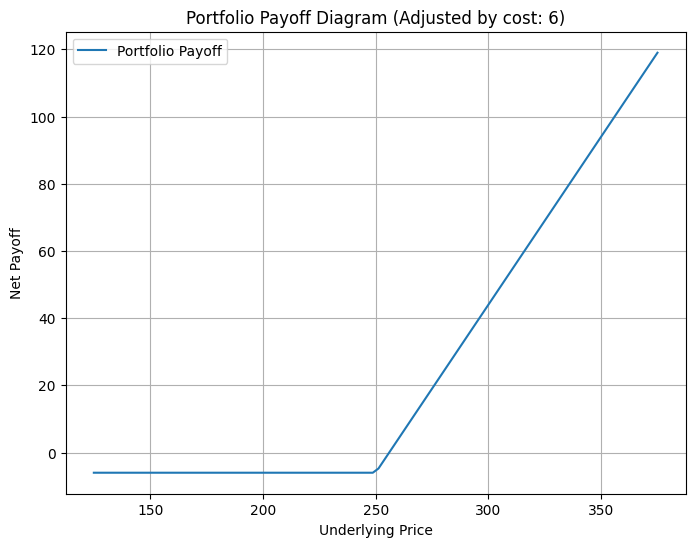

In [28]:
portfolio.plot_payoff(show_cost = True)

### strategy 4

In [18]:
portfolio = Portfolio()
portfolio.add_position(op)

### strategy 5

### strategy 6

### strategy 7